Asymptotics
===========

All warping algorithms implemented in ImWIP have an asymptotically linear time complexity. This notebook demonstrates this fact by timing the algorithms on varying image sizes. The results shown here are obtained on a system with these specs:

 - NVIDIA GeForce RTX 2080, with 7973MB
 - Intel(R) Core(TM) i7-9700F CPU @ 3.00GHz
 - 64GB RAM


In [1]:
import numpy as np
import cupy as cp
import imwip
from matplotlib import pyplot as plt
from timeit import timeit

In [2]:
def generate_data(im_size):
    im = cp.random.random((im_size,)*3).astype(np.float32)
    u = cp.random.random((im_size,)*3).astype(np.float32)
    v = cp.random.random((im_size,)*3).astype(np.float32)
    w = cp.random.random((im_size,)*3).astype(np.float32)
    out = cp.zeros((im_size,)*3, dtype=np.float32)
    return im, out, u, v, w

In [4]:
nruns = 10
times_warp = []
times_adjoint_warp = []
times_diff_warp = []
im_sizes = list(range(50, 550, 50))
for im_size in im_sizes:
    im, out, u, v, w = generate_data(im_size)
    
    time = timeit(lambda: imwip.warp(im, u, v, w, out=out, degree=3, backend="numba"), number=nruns)
    times_warp.append(time/nruns)
    
    time = timeit(lambda: imwip.adjoint_warp(im, u, v, w, out=out, degree=3, backend="numba"), number=nruns)
    times_adjoint_warp.append(time/nruns)

    time = timeit(lambda: imwip.diff_warp(im, u, v, w, diff_x=out, diff_y=out, diff_z=out, backend="numba"), number=nruns)
    times_diff_warp.append(time/nruns)

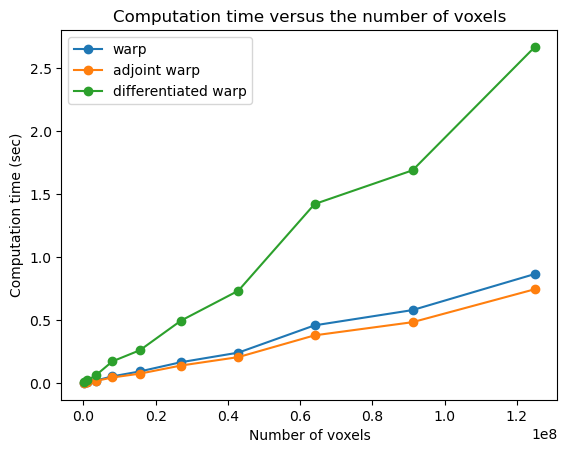

In [5]:
plt.figure()
plt.title("Computation time versus the number of voxels")
plt.plot([n**3 for n in im_sizes], times_warp, "-o")
plt.plot([n**3 for n in im_sizes], times_adjoint_warp, "-o")
plt.plot([n**3 for n in im_sizes], times_diff_warp, "-o")
plt.xlabel("Number of voxels")
plt.ylabel("Computation time (sec)")
plt.legend(["warp", "adjoint warp", "differentiated warp"])
plt.show()

The differentiated warp takes approximately 3 times as long as the regular and adjoint warp because 3 derivatives are computed: one to each component of the DVF.

The adjoint warp takes slightly longer than the regular warp because it cannot be fully parallelized. There can be race conditions which are resolved using cuda.atomic.add